# Assignment 4: Information Extraction

Hello everyone, this assignment notebook covers the **Information Extraction**. There are some code-completion tasks in this notebook. For each code completion task, please write down your answer (i.e., your lines of code) between sentences that `Your code starts here` and `Your code ends here`. The space between these two lines does not reflect the required or expected lines of code.

When you work on this notebook, you can insert additional code cells (e.g., for testing) or markdown cells (e.g., to keep track of your thoughts). However, before the submission, please remove all those additional cells again. Thanks!

**Important:**
* Remember to rename and save this Jupyter notebook as **A4_YourName_YourNUSNETID.ipynb** (e.g., **A4_BobSmith_e12345678.ipynb**) before submission!
* Remember to rename and save the script file **A4.py** as **A4_YourName_YourNUSNETID.py** (e.g., **A4_BobSmith_e12345678.py**) before submission! 
* Submission deadline is Apr 16, 11.59 pm. Late submissions will be penalized by 10% for each additional day.

Please also add your nusnet and student id in the code cell below. This is just to make any identification of your notebook doubly sure.

In [1]:
student_id = 'A0286188L'
nusnet_id = 'E1237250'

Here is an overview over the tasks to be solved and the points associated with each task. The notebook can appear very long and verbose, but note that a lot of parts are there to provide additional explanations, documentation, or some discussion. The code and markdown cells you are supposed to complete are well marked, but you can use the overview below to double-check that you covered everything.

* **1 Keyword Extraction (16 Points)**
    * 1.1 Implement RAKE (12 Points)
        * 1.1 a) Extracting all Candidates (3 Points)
        * 1.1 b) Calculating Term Scores (6 Points)
        * 1.1 c) Returning Top Keywords (3 Points)
    * 1.2 Limitations, Challenges, and Potential Improvements (4 Points)
* **2 Simple Text Summarization With TextRank (16 Points)**
    * 2.1 Calculating TextRank Scores (10 Points)
        * 2.1 a) Creating the Transition Matrix (2 Points)
        * 2.1 b) Implementing the Power Method (8 Points)
    * 2.2 Converting a Document to a Graph (6 Points)
        * 2.2 a) Preprocessing Sentences (2 Points)
        * 2.2 b) Creating Adjacency Matrix (4 Points)
* **3 Relation Extraction & Entity Linking (18 Points)**
    * 3.1 Extracting Hyponym Relationships (13 Points)
        * 3.1 a) Implement a Basic Hearst Pattern (8 Points)
        * 3.1 b) Limitations, Challenges, and Potential Improvements (5 Points)
    * 3.2 Entity Linking (5 Points)
        * 3.2 a) Limitations, Challenges, and Potential Improvements (5 Points)

### Notebook Setup

The following code cell ensures that the `.py` file gets automatically reloaded after you save any changes.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

from src.utils import plot_graph

np.set_printoptions(precision=3)

In [4]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

**Important:** This notebook also requires you to complete in a separate `.py` script file. This keeps this notebook cleaner and simplifies testing your implementations for us. As you need to rename the file `A4.py`, you also need to edit the import statement below accordingly.

In [5]:
from A4_VishwanathDattatreyaDoddamani_e1237250 import MyRAKE, MyTextRank, MyRelationExtractor
#from A4_BobSmith_e12345678 import MyRAKE, MyTextRank, MyRelationExtractor

---

## 1 Keyword Extraction (16 Points)

### 1.1 Implement RAKE (12 Points)

In this section, your task is to implement The RAKE algorithm. You can find the skeleton code for class `MyRAKE` in the `.py` file. As usual, this notebook will guide you step by step through the implementation process. 

RAKE (Rapid Automatic Keyword Extraction) is a simple algorithm used for automatic keyword extraction from text. The RAKE algorithm works by first splitting the text into segments (the keyword candidates), and then identifying the best keywords based on the scores for their individual terms (i.e., individual words). The score of a term is based on its frequency in the document and its co-occurrence with other terms.

One of the key features of the RAKE algorithm is that it uses a list of stopwords (common words like *"the"*, *"and"*, *"a"*, etc.) to filter out non-important words from consideration. It also allows for the inclusion of domain-specific stopwords and custom word delimiters, but which we ignore here. Overall, the RAKE algorithm is a fast and effective method for identifying important keywords in a text document, and can be useful in a variety of natural language processing tasks, such as text classification, information retrieval, and document summarization.

In the following, we use the short example text we used in the lecture. This allows you to directly compare the results.

In [6]:
text = "Keyword extraction is not that difficult after all. There are awesome libraries that can help you with keyword extraction. Rapid automatic keyword extraction is one of those."

# Analyze text with spaCy
doc = nlp(text)

#### 1.1 a) Extracting all Candidates (3 Points)

The first step of RAKE is to split the input text into segments. To keep it simple, we consider only 2 types of boundaries: **punctuation marks** and **stopwords** (i.e., you do not need to consider other possible boundaries such as parentheses/brackets, etc.).

**Task: Implement the method `extract_candidates()` to segment the input text!** Note that the input for this method is *not* the raw text but the document analyzed by `spaCy`. Not only does it take care of the tokenization, it also makes it very easy to identify the segment boundaries -- you can check out the examples on the [spaCy 101](https://spacy.io/usage/spacy-101) page. The method should return 2 outputs

* The list of all segments (i.e., keyword candidates), where each segment is a list of terms (cf. the expected example output below)

* The set of all terms (i.e., the vocabulary)

In [7]:
rake = MyRAKE()

candidates, vocabulary = rake.extract_candidates(doc)

print("List of Candidates:")
for cand in candidates:
    print("\t{}".format(cand))
print()
print("Vocabulary")
print(vocabulary)

List of Candidates:
	['keyword', 'extraction']
	['difficult']
	['awesome', 'libraries']
	['help']
	['keyword', 'extraction']
	['rapid', 'automatic', 'keyword', 'extraction']

Vocabulary
{'keyword', 'rapid', 'help', 'automatic', 'difficult', 'awesome', 'libraries', 'extraction'}


The expected output of the code cell above is:

```
List of Candidates:
	['keyword', 'extraction']
	['difficult']
	['awesome', 'libraries']
	['help']
	['keyword', 'extraction']
	['rapid', 'automatic', 'keyword', 'extraction']

Vocabulary
{'libraries', 'awesome', 'rapid', 'automatic', 'keyword', 'extraction', 'help', 'difficult'}
```

**Note:** The order of segments in `candidates` and the terms in `vocabulary` might differ depending on your exact implementation; and `vocabulary` is just a set anyway.

#### 1.1 b) Calculating Term Scores (6 Points)

RAKE first scores all terms individually. More specifically, the scores are computed for each score:

* Term Frequency $freq(t)$: total number of times term $t$ appears in the document

* Term Degree $deg(t)$: the number of times term $t$ is co-occurring with the other terms

The final score of a term $t$ is the calculated as

$$
score(t) = \frac{deg(t)}{freq(t)}
$$

**Task: Implement the method `calc_term_scores()` to calculate scores for each term according to the formula above!** With the description above and the example in the lecture slide, this should be very easy to implement.


In [8]:
term_scores = rake.calc_term_scores(candidates, vocabulary)

term_scores

{'keyword': 2.6666666666666665,
 'rapid': 4.0,
 'help': 1.0,
 'automatic': 4.0,
 'difficult': 1.0,
 'awesome': 2.0,
 'libraries': 2.0,
 'extraction': 2.6666666666666665}

The expected output of the code cell above is:

```
{'extraction': 2.6666666666666665,
 'awesome': 2.0,
 'rapid': 4.0,
 'libraries': 2.0,
 'difficult': 1.0,
 'keyword': 2.6666666666666665,
 'help': 1.0,
 'automatic': 4.0}
```

**Note:** The order of terms in `term_scores` might differ depending on your exact implementation.

#### 1.1 c) Returning Top Keywords (3 Points)

The last step is to score each candidate and return the candidates with the highest scores as the final keywords. Recall that the score of a candidate is simply the sum of the scores of its individual terms.

**Task: Implement the method `get_top_keywords()` to calculate scores of all candidates and return the highest-ranked candidates!**
 

In [9]:
top_keywords_scored = rake.get_top_keywords(candidates, term_scores, top=2)

top_keywords_scored

[('rapid automatic keyword extraction', 13.333333333333332),
 ('keyword extraction', 5.333333333333333)]

The expected output of the code cell above -- assuming `top=2` -- is:

```
[('rapid automatic keyword extraction', 13.333333333333332),
 ('keyword extraction', 5.333333333333333)]
```

### 1.2 Limitations, Challenges, and Potential Improvements (4 Points)

RAKE is a straightforward algorithm for keyword extraction. This makes it easy to implement and to understand the results. However, its simplicity also means the results can often be subpar compared to more sophisticated approaches -- and here we are only talking about other unsupervised methods! Let's have a look at your implementation of `MyRAKE`

**Question: What are the limitations of your `MyRAKE` class and/or the RAKE algorithm in general?** Hint: Consider what kind of keywords might be overemphasized or underemphasized by RAKE, or what other criteria that intuitively make a keyword are not considered by RAKE. For any limitation, **briefly sketch** how your implementation could be extended to reduce or even overcome this limitation.

**Note:** There is no single set of possible answers. This question aims to check your understanding of the algorithm and its limitations.

**Your Answer:** 

1) RAKE negatively affects the scores of a word if it is frequent. This might lead to RAKE underemphasizing words if the frequent word is actually a keyword (For ex: a paper about neural networks, consists 'neural network' a lot, and it is a keyword, but RAKE might not rank this higher). **Potential Solution**: Making use of dependency graph might address some of the issues such as if a word is parent of lot of words, then identifying compound word might result in better keyword extraction (RAKE would have underemphasized since the word might co-occur less with other words)

2) RAKE might overemphasize a certain word and miss out on a potential keyword. For example, climate change paper might contain 'climate' and 'change' with lot of other words. This might result in RAKE giving 'climate' and 'change' as separate keywords rather than 'climate change' which is an actual keyword. **Potential Solution**:  Using pos tagging might address the issue of overemphasizing. For example, words which are used as a noun can only be considered as candidates and this takes context into consideration resulting in better keyword extraction.

3) RAKE treats all words equally and does not take context into consideration. If a word is used in multiple context, then RAKE might overemphasize the word. **Potential Solution**: Utilize semantic analysis techniques to understand the underlying meaning and relationships between words. Words that are semantically related or co-occur frequently within the document should be given higher importance as keywords.


4) RAKE selects canidates based on segment boundaries. If a stopword is part of keyword, then it might miss out on potential keyword and wrongly identify candidate. For Example, the text 'Today we are going to learn Yet Another Keyphrase Extraction technique for keyword extraction', this will not identify 'Yet Another Keyphrase Extraction' as a candidate as 'Yet' and 'Another' are stopwords. **Potential Improvement**: If a stopword is not starting in the beginning and is capitalized, do not consider it as a segement boundary.

---

## 2 Simple Text Summarization With TextRank (16 Points)

The TextRank algorithm is a graph-based ranking algorithm for natural language processing and information retrieval. It was originally proposed in a 2004 paper by Rada Mihalcea and Paul Tarau. The algorithm works by representing a text as a graph, where each sentence is a node and the edges between the nodes represent the relationships between the sentences. These relationships are determined by measuring the similarity between pairs of sentences. The similarity measure can be based on various features of the text, such as word overlap, co-occurrence, and semantic similarity.

Once the graph has been constructed, the TextRank algorithm applies an iterative algorithm similar to Google's PageRank to rank the sentences based on their importance. The importance of a sentence is determined by its centrality within the graph, which takes into account both its own importance and the importance of the sentences it is connected to. The resulting ranked list of sentences can be used for various tasks, such as summarization, keyphrase extraction, and information retrieval. The TextRank algorithm has been shown to be effective and efficient, and has been used in many applications in natural language processing.

Your task in this section is to implement TextRank by completing the skeleton code of class `MyTextRank` in the `.py` file. We saw in the lecture that TextRank can be used for keyword extraction (words become nodes) and sentence extraction (sentences become nodes) for simple document summarization. In this section, we focus on the latter.

### 2.1 Calculating TextRank Scores (10 Points)

We start by implementing the Power Method to calculate the PageRank scores for a given graph. This means we assume that we already have converted our input text into a graph -- we will do this later. For this part, we use the same graph that we have seen in the lecture slides, so you can easily compare the results. Let's first create the graph by means of its adjacency matrix, and plot the graph. For the plotting, we provide you with the method `plot_graph()` you can find in `src/utils.py`.


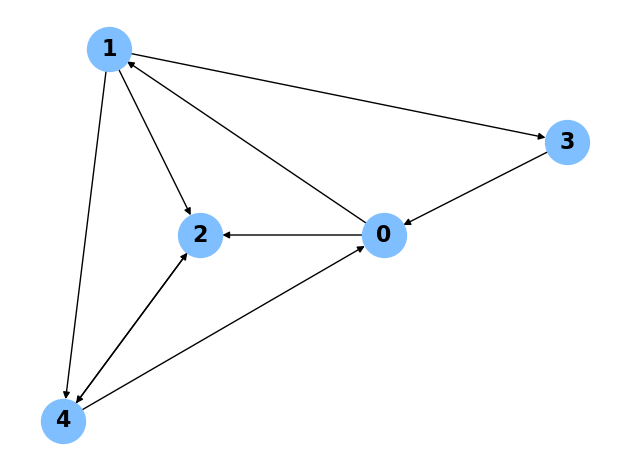

In [14]:
A = np.array([
    [0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0],
], dtype=np.float64)

plot_graph(A, pos={0:(0,0), 1:(-6,2), 2:(-4,0), 3:(4,1), 4:(-7,-2)})

#### 2.1 a) Creating the Transition Matrix (2 Points)

We saw in the lecture that computing the PageRank scores of nodes in a graph translates to calculating the largest Eigenvector of the respective transition matrix `M`. The transition matrix `M` can be computed by transposing the adjacency matrix `A` and normalizing it so the column values sum up to 1, making `M` column-stochastic.

**Task: Implement the method `create_transition_matrix()` to calculate the transition matrix!** With the description above and the example in the lecture slide, this should be very easy to implement.


In [15]:
textrank = MyTextRank()

M = textrank.create_transition_matrix(A)

print("Transition Matrix M:")
print(M)

Transition Matrix M:
[[0.    0.    0.    1.    0.5  ]
 [0.5   0.    0.    0.    0.   ]
 [0.5   0.333 0.    0.    0.5  ]
 [0.    0.333 0.    0.    0.   ]
 [0.    0.333 1.    0.    0.   ]]


The expected output of the code cell above is:

```
Transition Matrix M:
[[0.    0.    0.    1.    0.5  ]
 [0.5   0.    0.    0.    0.   ]
 [0.5   0.333 0.    0.    0.5  ]
 [0.    0.333 0.    0.    0.   ]
 [0.    0.333 1.    0.    0.   ]]
```

#### 2.1 b) Implementing the Power Method (8 Points)

With the transition matrix `M` we can now compute the PageRank score for each node. Recall that PageRank was defined as

$$
PR(v) = \alpha\cdot M\cdot PR(v) + (1-\alpha)\cdot E
$$

where $E = (1/n, 1/n, ..., 1/n)^T$ with $n$ being the number of nodes.

**Task: Implement the `power_method()` to compute the largest Eigenvector of input matrix M!** The lecture slides include the algorithm for the Power Method in pseudo code. Note, however, that you need to extend the algorithm slightly to accommodate the PageRank-specific details (e.g., your implementation needs to reflect damping factor $\alpha$ and vector $E$).


In [16]:
scores = textrank.power_method(M)

print("All nodes with their PageRank scores:")
for node, score in scores.items():
    print("Node {}: {:.3f}".format(node, score))

All nodes with their PageRank scores:
Node 0: 0.216
Node 1: 0.122
Node 2: 0.288
Node 3: 0.065
Node 4: 0.309


The expected output of the code cell above is:

```
All nodes with their PageRank scores:
Node 0: 0.216
Node 1: 0.122
Node 2: 0.288
Node 3: 0.065
Node 4: 0.309
```

### 2.2 Converting a Document to a Graph (6 Points)

With the implementation of the PageRank scores in place, we can now address the step of converting an input document into the graph. Again, here we consider TextRank for summarization, meaning that the text units that become the nodes in the graph are complete sentences -- and not individual words like for keyword extraction. For easy testing of your implementation, we consider the toy corpus from Lecture 7 as our input document. This means, we have the following 4 sentences:

In [17]:
sentences = [
    "The mayor was elected for this term and next term.",
    "A mayor's goal for the next term is to win.",
    "The goal for this term was to win the vote.",
    "This term's goals are next term's goals.",
    "The goal of any team player is the win.",
    "A win for the team is a win for each player.",
    "Players vote other players for another term."
]

In practice, it is unlikely that we would find those 7 sentences in the same document, but it is just for illustrative purposes here.

#### 2.2 a) Preprocessing Sentences (2 Points)

We know that eventually, we need to compute the similarity between sentences to determine the edge weights between the respective nodes. Apart from the selected similarity metric itself, we already know that preprocessing has a significant effect on the result. To be consistent, we perform the following preprocessing steps:

* Remove all punctuation marks (i.e., only alphanumeric tokens)
* Remove all stop words
* Lemmatize all words
* Lowercase all words

**Task: Implement the first part of the method `convert_text_to_graph()` to preprocess the list of input sentences!** Hint: The `.py` file already imports `spacy` which we highly recommend to use; Check out the docs for the [spaCy token](https://spacy.io/api/token), especially the attributes `is_stop` and `is_alpha` to make your life much easier.


In [18]:
textrank = MyTextRank()

textrank.convert_text_to_graph(sentences, preprocess_only=True)

['mayor elect term term',
 'mayor goal term win',
 'goal term win vote',
 'term goal term goal',
 'goal team player win',
 'win team win player',
 'player vote player term']

The expected output of the code cell above is:

```
['mayor elect term term',
 'mayor goal term win',
 'goal term win vote',
 'term goal term goal',
 'goal team player win',
 'win team win player',
 'player vote player term']
```

This should also match the example in Lecture 4.

#### 2.2 b) Creating Adjacency Matrix (4 Points)

In the case of sentences being text units represented as nodes, the edge -- or more specifically the weight of the edge --  between 2 nodes is derived from the similarity between the respective sentences. There are various ways to compute the similarity between sentences (e.g., Jaccard Similarity, Cosine Similarity), but here we adhere to the metric proposed in the [original paper](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf).

In the paper, the similarity between 2 sentences is derived from the number of tokens/words both sentences have in common. To avoid promoting long sentences, the paper uses a normalization factor. The formula for calculating the similarity is thus as follows:

$$
Similarity(S_i, S_j) = \frac{| \{w_k\ |\ w_k \in S_i \wedge w_k \in S_j \} |}{\log{|S_i|} + \log{|S_j|}}
$$

where $\log$ refers to the natural logarithm. Note that $S_i$ and $S_j$ are **sets of words** and not lists/sequences here.

**Task: Implement the second part of the method `convert_text_to_graph()` to compute the sentence similarities!** The output of this method is a matrix representing the adjacency matrix of the result graph -- that is, the size of the matrix is $N\times N$ with $N$ being the number of nodes/sentences, and the values representing the weights of the edges. Note that, since the similarity metric is symmetric, the output matrix also has to me symmetric w.r.t. the main diagonal.


In [19]:
textrank = MyTextRank()

A = textrank.convert_text_to_graph(sentences, preprocess_only=False)

print("Adjacency matrix derived from example sentences.")
print(A)

Adjacency matrix derived from example sentences.
[[0.    0.805 0.402 0.558 0.    0.    0.455]
 [0.805 0.    1.082 0.962 0.721 0.402 0.402]
 [0.402 1.082 0.    0.962 0.721 0.402 0.805]
 [0.558 0.962 0.962 0.    0.481 0.    0.558]
 [0.    0.721 0.721 0.481 0.    1.207 0.402]
 [0.    0.402 0.402 0.    1.207 0.    0.455]
 [0.455 0.402 0.805 0.558 0.402 0.455 0.   ]]


The expected output of the code cell above is:

```
Adjacency matrix derived from example sentences.
[[0.    0.805 0.402 0.558 0.    0.    0.455]
 [0.805 0.    1.082 0.962 0.721 0.402 0.402]
 [0.402 1.082 0.    0.962 0.721 0.402 0.805]
 [0.558 0.962 0.962 0.    0.481 0.    0.558]
 [0.    0.721 0.721 0.481 0.    1.207 0.402]
 [0.    0.402 0.402 0.    1.207 0.    0.455]
 [0.455 0.402 0.805 0.558 0.402 0.455 0.   ]]
```

#### Putting Everything Together (nothing for you to do here)

You have implemented all core methods of class `MyTextRank`. Note we already give you the method `run()` that calls each of those methods to compute PageRank scores for an input document (with the input document being represented as a list of sentences).


In [20]:
textrank = MyTextRank()

scores = textrank.run(sentences)
    
print("All nodes with their PageRank scores:")
for node, score in scores.items():
    print("Sentence {}: {:.3f}".format(node, score))

All nodes with their PageRank scores:
Sentence 0: 0.100
Sentence 1: 0.180
Sentence 2: 0.180
Sentence 3: 0.148
Sentence 4: 0.149
Sentence 5: 0.110
Sentence 6: 0.133


The expected output of the code cell above is:

```
All nodes with their PageRank scores:
Sentence 0: 0.100
Sentence 1: 0.180
Sentence 2: 0.180
Sentence 3: 0.148
Sentence 4: 0.149
Sentence 5: 0.110
Sentence 6: 0.133
```

---

## 3 Relation Extraction & Entity Linking (18 Points)

Relation extraction involves identifying semantic relationships between entities in a text. In other words, it is the process of automatically identifying and extracting structured information about the relationships between two or more entities mentioned in a piece of text. The entities can be anything from people and organizations to locations, products, and events. Relation extraction involves identifying the type of relationship between these entities, such as "works for," "is married to," "is located in," "causes," "part of," "owned by," and so on. In this section, we focus on "is a" (i.e., hyponym) relationship.


### 3.1 Extracting Hyponym Relationships (13 Points)

In this section, your task is to implement a simple relation extraction algorithm. You can find the skeleton code for class `MyRelationExtractor` in the `.py` file.

A hyponym relationship is a hierarchical relationship between words or concepts, where one term (the hyponym) is a specific instance of another term (the hypernym). In other words, a hyponym is a term that is subordinate or more specific in meaning to a more general or superordinate term, which is the hypernym. For example, "apple" is a hyponym of "fruit," since apple is a specific type of fruit. The hyponym relationship is often used in taxonomies and ontologies to organize concepts in a hierarchical structure, where the hypernym is at the top of the hierarchy, and the hyponyms are arranged beneath it. 

Your task is to extract hyponym relationships using Hearst patterns, a set of linguistic patterns developed by Marti Hearst. Hearst's patterns are based on the observation that certain syntactic patterns in text can signal a hyponym-hypernym relationship between two nouns. For example, the pattern "X, such as Y" often indicates that X is a hypernym of Y. So, in the sentence "Fruits, such as apples and oranges," "fruits" is the hypernym, and "apples" and "oranges" are the hyponyms.

Let's first have a look at the example sentences:

In [21]:
such_as_sentences = [ line.strip() for line in open("data/a4-example-sentences.txt")]

for s in such_as_sentences:
    print(s)

John McTiernan directed many action movies such as Die Hard, Predator, and Rollerball.
The shop specialises in tropical fruits, such as pineapples, mangoes or bananas.
Aerobic exercises, such as jogging and running, are good for your stamina and heart.
Louie has traveled to several places, such as Los Angeles, Chicago, and San Francisco.


As you can see, all example include the **"X such as Y"** or **"X, such as Y"** Heart's pattern; and this is the only pattern we are considering here to keep things simple. To further simplify things, **you do not have to work on the raw input sentence** but instead can use spaCy for a basic analysis. Most importantly, spaCy computes the dependency between words, which is very useful for our task.

To give an example, let's look at the dependency of the first sentence:

In [22]:
doc = nlp(such_as_sentences[2])

displacy.render(doc, style="dep")

#### 3.1 a) Implement Basic Hearst Pattern (8 Points)

As you can see, the dependency tree gives a very good idea how to find the **X** and the **Y** in the **X, such as Y** pattern.

**Task: Implement the  method `extract_such_as_hyponyms()` to extract all "X, such as Y" hyponym relationships in a sentence!** While you can do this however you want, we recommend using the spaCy and the resulting dependency tree for each sentence. (Hint: Have a look at the documentation for [spaCy tokens](https://spacy.io/api/token); particularly [`Token.conjuncts`](https://spacy.io/api/token#conjuncts), [`Token.ancestors`](https://spacy.io/api/token#ancestors), and [`token.children`](https://spacy.io/api/token#children) might come in very handy!)

We also provide you with the method `get_compound()` to get all tokens that form a compound word (e.g., "action movies")

**IMPORTANT:** In this subtask, you only need to get the correct results for the example sentences; cf. the expected outcome below. Also, depending on your exact setup, you might miss some relationships, mainly *"jogging" IS-A "exercise"* and/or *"running" IS-A "exercise"*. This can be caused if the POS tagger will tag *jogging* and *running* as a noun or a verb. In the latter case, you won't get those relationships. It's perfectly fine if that is the case, you don't need to fix this!


In [23]:
rel_extractor = MyRelationExtractor()

hyponyms = []
for s in such_as_sentences:
    hyponyms.extend(rel_extractor.extract_hyponyms(s))
    
for h in hyponyms:
    print('"{}" IS-A "{}"'.format(h[0], h[1]))

"predator" IS-A "action movie"
"rollerball" IS-A "action movie"
"die hard" IS-A "action movie"
"mango" IS-A "fruit"
"banana" IS-A "fruit"
"pineapple" IS-A "fruit"
"running" IS-A "exercise"
"jog" IS-A "exercise"
"chicago" IS-A "place"
"san francisco" IS-A "place"
"los angeles" IS-A "place"


The expected output of the code cell above is:

```
"die hard" IS-A "action movie"
"predator" IS-A "action movie"
"rollerball" IS-A "action movie"
"pineapple" IS-A "fruit"
"mango" IS-A "fruit"
"banana" IS-A "fruit"
"jogging" IS-A "exercise"
"running" IS-A "exercise"
"los angeles" IS-A "place"
"chicago" IS-A "place"
"san francisco" IS-A "place"
```

#### 3.1 b) Limitations, Challenges, and Potential Improvements (5 Points)

If your implementation of `extract_such_as_hyponyms()` handles all 4 example sentences correctly then this is a good start. However, and this shouldn't be surprising, your method is unlikely to be perfect. Let's do some critical analysis of your implementation. **There is nothing to implement here!**

**Question: What are the limitations of your `extract_such_as_hyponyms()` method?** Hint: Come up with additional example sentences where the results in terms of found hyponym relationships are not as expected or at least questions. For each example, **briefly** describe the reason for the incorrect/questionable result, and **briefly** sketch an idea for a possible solution. If your implementation is indeed perfect, and you have nothing to report for 3.1 b), we will acknowledge this :).


**Your Answer:**
1) Complex Sentence Structure: The implemented method does not correctly identify hyponym-hypernym relation in complex sentences. For example, 'He loves celebrating events such as the festival of Holi' this sentence returns 'festival is a event', it should return 'holi is a event'. **Potential Solution**: Improve the dependency parsing and pattern matching to handle nested structures.
2) Compound Words: If the sentence fails to identify compound word then it might lead to incorrect results. For example,  'He acted in many plays such as welcoming neighbors, bad neighbors' this sentence returns 'welcome is a play', it should return 'welcoming neighbors is a play'. **Potential Solution**: Make use of punctuation marks and improve dependency parsing.
3) Noun phrases: If the sentence contain noun phrase then this might lead to incorrect results. For example, 'Common flavors of ice cream such as chocolate and vanilla are my favorite' this sentence returns 'vanilla is a ice cream', it should return 'vanilla is a flavor'. **Potential Solution**: Improve pattern matching (look for tokens not just before 'such as') and then make use of dependecy parsing.
4) Conjuncts: If the sentence has compound conjuncts, then this might fail to identify certain conjuncts. For example, 'He likes activities such as mountain climbing, rock climbing' this sentence only identifies 'mountain climbing is a activity' and fails to identify 'rock climbing is a activity'. **Potential Solution**: Look for parents of the tokens is 'as' and not just children of 'as'.
5) Context: The result might not reflect the context in which it is intended and incorrectly identify hypernym. For example, 'He likes activities which are adventurous such as mountain climbing, rock climbing' this returns 'mountain climbing is a adventure', while this is not necessarily incorrect, but depending on the context, the result might be more accurate if it return 'mountain climbing is a activity'. **Potential Solution**: This is a challenge and might need context information or text of previous sentences to effectively parse.

### 3.2 Entity Linking (5 Points)

In 3.1, we extracted hyponym relationships from sentences, but so far we only have the mentions -- that is, the phrases that represent named entities or concepts in a hyponym relationship. What we often want in practice is to link those mentions to their corresponding real-world entities or concepts. The goal is to disambiguate named entities or phrases by linking them to their respective nodes in a knowledge graph -- or create or extend an existing knowledge graph.

While there are many different approaches, this is of course not a trivial task to get it right. A very basic one is to use a search or text retrieval engine to return the most likely knowledge graph node for a given mention (used as a search term). The class `MyRelationExtractor` already provides you with a simple method `get_wikipedia_urls()` that returns to top-k Wikipedia article URLs for a given search term. You can use the code cell below to check it out:


In [24]:
rel_extractor.get_wikipedia_urls("game of thrones", topk=15)

['https://en.wikipedia.org/wiki/Game_of_Thrones',
 'https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire',
 'https://en.wikipedia.org/wiki/Game_of_Thrones_(2014_video_game)',
 'https://en.wikipedia.org/wiki/Game_of_Thrones_(2012_video_game)',
 'https://en.wikipedia.org/wiki/Game_of_Thrones_season_1',
 'https://en.wikipedia.org/wiki/Game_of_Thrones_season_2']

Using the method `get_wikipedia_urls()`, we can now convert the mentions forming the hyponym relationships we found in 3.1 into their respective Wikipedia article URLs.

In [25]:
for h in hyponyms:
    X = rel_extractor.get_wikipedia_urls(h[0])[0]
    Y = rel_extractor.get_wikipedia_urls(h[1])[0]
    print('{} IS-A {}'.format(X, Y))

https://en.wikipedia.org/wiki/Predation IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Rollerball_(1975_film) IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Die_Hard IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Mango IS-A https://en.wikipedia.org/wiki/Fruit
https://en.wikipedia.org/wiki/Banana IS-A https://en.wikipedia.org/wiki/Fruit
https://en.wikipedia.org/wiki/Pineapple IS-A https://en.wikipedia.org/wiki/Fruit
https://en.wikipedia.org/wiki/Running IS-A https://en.wikipedia.org/wiki/Exercise
https://en.wikipedia.org/wiki/Zionist_Occupation_Government_conspiracy_theory IS-A https://en.wikipedia.org/wiki/Exercise
https://en.wikipedia.org/wiki/Chicago IS-A https://en.wikipedia.org/wiki/Location
https://en.wikipedia.org/wiki/San_Francisco IS-A https://en.wikipedia.org/wiki/Location
https://en.wikipedia.org/wiki/Los_Angeles IS-A https://en.wikipedia.org/wiki/Location


The output should look like this:

```
https://en.wikipedia.org/wiki/Die_Hard IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Predator_(film) IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Rollerball_(1975_film) IS-A https://en.wikipedia.org/wiki/Action_film
https://en.wikipedia.org/wiki/Pineapple IS-A https://en.wikipedia.org/wiki/Culinary_fruit
https://en.wikipedia.org/wiki/Mango IS-A https://en.wikipedia.org/wiki/Culinary_fruit
https://en.wikipedia.org/wiki/Banana IS-A https://en.wikipedia.org/wiki/Culinary_fruit
https://en.wikipedia.org/wiki/Jogging IS-A https://en.wikipedia.org/wiki/Exercise
https://en.wikipedia.org/wiki/Running IS-A https://en.wikipedia.org/wiki/Exercise
https://en.wikipedia.org/wiki/Los_Angeles IS-A https://en.wikipedia.org/wiki/Region
https://en.wikipedia.org/wiki/Chicago IS-A https://en.wikipedia.org/wiki/Region
https://en.wikipedia.org/wiki/San_Francisco IS-A https://en.wikipedia.org/wiki/Region
```

#### 3.2 a) Limitations, Challenges, and Potential Improvements (5 Points)

Similar to 3.1, everything works out quite nicely since the example sentences are rather "convenient". So once again, we should discuss when this approach might fail and why, as well as contemplate how we could address this in practice. **There is nothing to implement here!**

**Question: What are the limitations of the `get_wikipedia_urls()` method?** Hint: Come up with examples the results in terms of found Wikipedia articles URLs are wrong or at least questionable. For each example, **briefly** describe what the reason for the incorrect/questionable result might be, and **briefly** sketch any extension to the method `get_wikipedia_urls()` for improvements.

**Your Answer:**
1) Context: This method fails to identify the context of hyponym and hypernym and just gives top result. For example (Apple, Tech) this should return page of 'Apple the tech company' however it gives page of 'fruit'. This is because it treats all words equally and does not take context into consideration. **Potential Extension of solution**: To consider context, filter the links that contain both hyponym and hypernym.
2) Out of Vocabulary Words: This method does not retrive any links if it is not able to fetch results for a text: For example (Apple Tech, Innovation) will throw an error because it cannot fetch 'Apple Tech'. Potential **Extension**: Split the hyponym and then retrive the results.
3) Single Source Dependency: The implemented method is only on wikipedia api which limits the scope and gives irrelevant links at times. For example (Mississippi, Bank) should give details about Mississippi river bank but it gives url of city Mississippi and gives url of a finanacial bank. **Potential Extension**: Give results from diverse sources. If domain knowledge is known then use the api of the domain specific apis if available.
4) Limited Results: Since this implementation gives only top result for a word, it misses out on potential results which are lower in rank, thus under emphasizing certain links. **Potential Improvement**: Give links more weightage if it has the relevant keyword (for example joining hyponym and hypernym might act as a keyword) and then re-rank the results. One more solution might be to consider results from diverse apis and then have a voting.
5) Multi Positional Word: This implementation might fail to correctly identify the links if the word is a multi functional word. For example, run can be a noun, adjective, adverb or a verb. This implementation only gives links for running as an exercise. **Extension**: Use POS tagging while searching and then rank the results.